# 주가 예측 모델을 위한 기본 코드 

In [7]:
import os
import pickle
import quandl
quandl.ApiConfig.api_key = 'JJH1Z7c2NDeRw278rr6H'
import numpy as np

## making cosine signal  

In [8]:
def fetch_cosine_values(seq_len, frequency = 0.01, noise = 0.1):
    np.random.seed(101)
    x = np.arange(0.0, seq_len, 1.0) #numpy.arange([start, ] stop, [step, ] dtype=None)
    return np.cos(2 * np.pi *frequency * x) + np.random.uniform(low = noise, high = noise, size = seq_len)
    

In [9]:
print(fetch_cosine_values(10,frequency=0.1))

[ 1.1         0.90901699  0.40901699 -0.20901699 -0.70901699 -0.9
 -0.70901699 -0.20901699  0.40901699  0.90901699]


In [10]:
import matplotlib.pyplot as plt

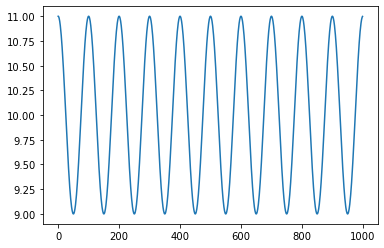

In [11]:
plt.plot(fetch_cosine_values(1000,frequency=0.01, noise=10))

## 조정가 추출 

In [12]:
#datetime.date를 API에서 필요로 하는 문자열 형식으로 변환하는 함수
def date_obj_to_str(date_obj):
    return date_obj.strftime('%Y-%m-%d')

In [13]:
def save_pickle(something, path):
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    with open(path, 'wb') as fh:
        pickle.dump(something, fh, pickle.DEFAULT_PROTOCOL)
def load_pickle(path):
    with open(path, 'rb') as fh:
        return pickle.load(fh)

In [14]:
#from_date에서 to_date로 졍렬되어, 요청한 종목 기호에 대한 주가를 포함한 일차원 배열을 반환
def fetch_stock_price(symbol, from_date, to_date, cache_path='./tmp/prices/'):
    assert from_date <= to_date, "from_date가 to_date보다 큼!"
    
    filename = "{}_{}_{}.pk".format(symbol, str(from_date),str(to_date))
    price_filepath = os.path.join(cache_path, filename)
    
    try:
        prices = load_pickle(price_filepath)
        print("loaded from", price_filepath)
    except IOError:
        historic = quandl.get("WIKI/"+symbol,
                             start_date = date_obj_to_str(from_date),
                             end_date = date_obj_to_str(to_date))
        prices = historic["Adj. Close"].tolist()
        save_pickle(prices, price_filepath)
        print("saved into", price_filepath)
    return prices

In [15]:
import datetime
sample = fetch_stock_price("GOOG",datetime.date(2017,1,1),datetime.date(2017,1,11))

loaded from ./tmp/prices/GOOG_2017-01-01_2017-01-11.pk


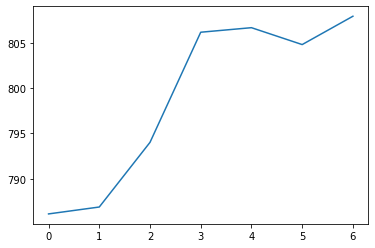

In [16]:
plt.plot(sample)

In [17]:
#Sliding window를 통해, 특징 크기를 특정하게 정하는 함수
#label은 반복할 때마다 슬라이딩 윈도우 끝에 따라오는 값 (특징에 해당되지 않고 직후 값)
def format_dataset(values, temporal_features):
    feat_splits = [values[i:i+temporal_features] for i in range(len(values)-temporal_features)]
    feats = np.vstack(feat_splits) #두 배열을 위에서 아래로 붙이기
    labels = np.array(values[temporal_features:])
    return feats,labels

In [9]:
#행렬을 일차원 배열로 변환하는 함수
def matrix_to_array(m):
    return np.asarray(m).reshape(-1)
#np.array -> ndarray 생성 가능
#np.asarray -> input(list,tuple 등)을 array로 전환